# Quantum Reservoir Computing for a Linear Recurrence

We study the scalar linear recurrence
$
y(t+1) = \alpha\,y(t) + \beta\,y(t-1),
\qquad y(0)=A,\;y(1)=B,
$
and use a **2-qubit Quantum Reservoir Computer (QRC)** to learn the one-step map  
$y(t)\mapsto y(t+1)$.

The pipeline is:

1. Generate the true time series $y(t)$.
2. Normalize $y(t)$ to $[0,1]$ for amplitude encoding.
3. Evolve a 2-qubit reservoir with a controlled-$R_y(phi)$ gate.
4. Measure observables on input and memory qubits to get a feature vector
   $\mathbf x(t) = [\langle X_I\rangle,\langle Z_I\rangle,\langle X_M\rangle,\langle Z_M\rangle]$.
5. Train a **ridge readout**
   $
   W^\star(\phi) = \arg\min_W \|\tilde X(\phi)W - \mathbf y\|_2^2 + \lambda\|W\|_2^2
   $
   under **teacher forcing**.
6. Use the learned $(\phi^\star, W^\star)$ to make **autoregressive predictions**.



In [ ]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
sys.path.append(str(ROOT / "src"))

from ar2 import *  
from normalization import *
from plotting import *
from qrc_model import *
from training import *

In [ ]:
alpha = 1/2
beta  = 1/2

A = 1.0       
B = 0.0       

T_TOTAL  = 15   
T_TRAIN  = 2    
LAMBDA   = 1e-2 

print(f"Recurrence: y(t+1) = {alpha} y(t) + {beta} y(t-1)")
print(f"Initial conditions: y(0)={A}, y(1)={B}")
print(f"Total horizon: 0..{T_TOTAL}, training up to t={T_TRAIN}")

t_all = np.arange(0, T_TOTAL + 1)
y_all = generate_linear_series(alpha, beta, A, B, T_TOTAL)

print("First raw values:", np.round(y_all[:8], 4))

Recurrence: y(t+1) = 0.5 y(t) + 0.5 y(t-1)
Initial conditions: y(0)=1.0, y(1)=0.0
Total horizon: 0..15, training up to t=2
First raw values: [1.     0.     0.5    0.25   0.375  0.3125 0.3438 0.3281]


## 1. Normalizing the time series

The QRC encodes each scalar input \(y(t)\) as a qubit amplitude, so we first map
the raw values to the interval \([0,1]\):

$$
y_{\text{norm}}(t) = \frac{y(t) - y_{\min}}{y_{\max} - y_{\min}}.
$$

We keep the inverse map to convert predictions back to the original scale.


In [ ]:
scaler = MinMaxScaler.fit(y_all)

print("Raw y range:", scaler.y_min, "→", scaler.y_max)

y_norm_all = scaler.transform(y_all)

print("First normalized values:", np.round(y_norm_all[:8], 4))


Raw y range: 0.0 → 1.0
First normalized values: [1.     0.     0.5    0.25   0.375  0.3125 0.3438 0.3281]


## 2. Quantum reservoir primitives

We use a 2-qubit reservoir:

- Input qubit $I$: encodes the scalar $y(t)$ by amplitude.
- Memory qubit $M$: carries the internal state across time.

Encoding of a normalized value $y \in [0,1]$:

$$
\ket{\psi_I(y)} = \sqrt{1-y}\,\ket{0} + \sqrt{y}\,\ket{1},
\qquad
\rho_I(y) = \ket{\psi_I}\bra{\psi_I}.
$$

The reservoir unitary is a **controlled-\(R_y(\phi)\)** from input to memory:

$$
U(\phi)
= \ket{0}\bra{0}\otimes I + \ket{1}\bra{1}\otimes R_y(\phi).
$$

We then:

1. Build $\rho_{IM}(t) = \rho_I(t) \otimes \rho_M(t)$.
2. Evolve $\rho_{\text{res}}(t) = U(\phi)\,\rho_{IM}(t)\,U(\phi)^\dagger$.
3. Update memory $\rho_M(t+1) = \mathrm{Tr}_I[\rho_{\text{res}}(t)]$.
4. Measure $\langle X_I\rangle,\langle Z_I\rangle,\langle X_M\rangle,\langle Z_M\rangle$.


In [ ]:
print("QRC primitives loaded: X, Z, I2, encode_input_density, Ry, CRy_I_to_M, partial_trace_over_input, exp_I, exp_M.")

QRC primitives loaded: X, Z, I2, encode_input_density, Ry, CRy_I_to_M, partial_trace_over_input, exp_I, exp_M.


## 3. One QRC step and feature extraction

For a given angle $\phi$, memory state $\rho_M(t)$, and normalized input
$y_{\text{norm}}(t)$, one **QRC step** does:

1. Encode $y_{\text{norm}}(t)$ into $\rho_I(t)$.
2. Build $\rho_{IM}(t) = \rho_I(t) \otimes \rho_M(t)$.
3. Apply $U(\phi)$.
4. Update memory $\rho_M(t+1) = \mathrm{Tr}_I[\rho_{\text{res}}(t)]$.
5. Measure the feature vector
   $
   \mathbf{x}(t) = \bigl(\langle X_I\rangle,\langle Z_I\rangle,
   \langle X_M\rangle,\langle Z_M\rangle\bigr).
   $

We also define a version that immediately applies the linear readout $y_{\text{norm}}(t+1) = W^\top \mathbf{x}(t)$.


In [ ]:
print("Loaded: qrc_step_features, qrc_step_with_readout.")

Loaded: qrc_step_features, qrc_step_with_readout.


## 4. Design matrix and ridge training under teacher forcing

On the training window $t = 0,\dots,T_{\text{train}}-1$ we use **teacher forcing**:
the input at time $t$ is the **true** normalized value $y_{\text{norm}}(t)$,
independent of model predictions.

For each $t$ in the training window we compute:

- features $\mathbf{x}(t)$
- target $y_{\text{norm}}(t+1)$

and stack them into a design matrix $X(\phi)$ and target vector $\mathbf{y}$.  
We then solve the ridge regression:

$$
W^\star(\phi)
= \bigl(X^\top X + \lambda I\bigr)^{-1} X^\top \mathbf{y}.
$$


## 5. Selecting the best reservoir angle $\phi^\star$

We scan a grid of angles $\phi \in [0,2\pi]$, train a ridge readout
for each one, and keep the angle that gives the **smallest training MSE**.
This gives $\phi^\star$ and $W^\star$.


In [ ]:
t_start_train = 0
t_end_train   = T_TRAIN  

# Grid of candidate reservoir angles
phis = np.linspace(0.0, 2 * np.pi, 181) 

phi_star, W_star, losses, W_list = scan_phi_grid(
    phis=phis,
    y_norm_series=y_norm_all,
    t_start=t_start_train,
    t_end=t_end_train,
    lam=LAMBDA,
)

print("\n============================")
print("Best phi* =", phi_star)
print("Min training MSE (normalized) =", losses.min())
print("W*(phi*) = ", W_star)



Best phi* = 0.0
Min training MSE (normalized) = 3.0939828222072047e-06
W*(phi*) =  [0.         0.24875622 0.         0.24875622]


## 6. Autoregressive rollout with $(\phi^\star, W^\star)$

1. First, we **replay the training window** with teacher forcing to bring
   the memory qubit to the correct state $\rho_M(T_{\text{train}})$.
2. Then, from $t = T_{\text{train}},\dots,T_{\text{total}}-1$,
   we run **autoregressively**:
   - input at time $t$: model prediction from the previous step,
     $y_{\text{norm}}^{\text{in}}(t)$,
   - output: $y_{\text{norm}}^{\text{hat}}(t+1) = W^{\star\top} \mathbf{x}(t)$.

Predictions are converted back to the raw scale using the inverse normalization.


In [ ]:
# AUTOREGRESSIVE ROLLOUT WITH (φ*, W*)

# Prepare memory state by teacher forcing on training window
rho_M = warmup_memory(
    phi=phi_star,
    W=W_star,
    y_norm_series=y_norm_all,
    t_start=t_start_train,
    t_end=t_end_train,
)

# Autoregressive predictions from t = T_TRAIN
t_start_pred = T_TRAIN
t_end_pred   = T_TOTAL

t_pred, y_pred_norm = autoregressive_rollout(
    phi=phi_star,
    W=W_star,
    y_norm_series=y_norm_all,
    t_start_pred=t_start_pred,
    t_end_pred=t_end_pred,
    rho_M_init=rho_M,
)

y_pred_raw = scaler.inverse_transform(y_pred_norm)

# Compute test errors on raw scale (t > T_TRAIN)
y_true_test = y_all[t_pred]
abs_err = np.abs(y_pred_raw - y_true_test)
rel_err = abs_err / np.maximum(np.abs(y_true_test), 1e-12)

print("\nTest region: t from", t_start_pred + 1, "to", t_end_pred)
print("Mean absolute error (raw) =", abs_err.mean())
print("Mean relative error (raw) =", rel_err.mean())



Test region: t from 3 to 15
Mean absolute error (raw) = 0.0011214919266909335
Mean relative error (raw) = 0.0034360982606963467


## 7. Plot: true vs QRC predictions

We finally compare:

- the true recurrence $y(t)$ (raw scale),
- the values used in the training region,
- the QRC autoregressive predictions beyond $T_{\text{train}}$.


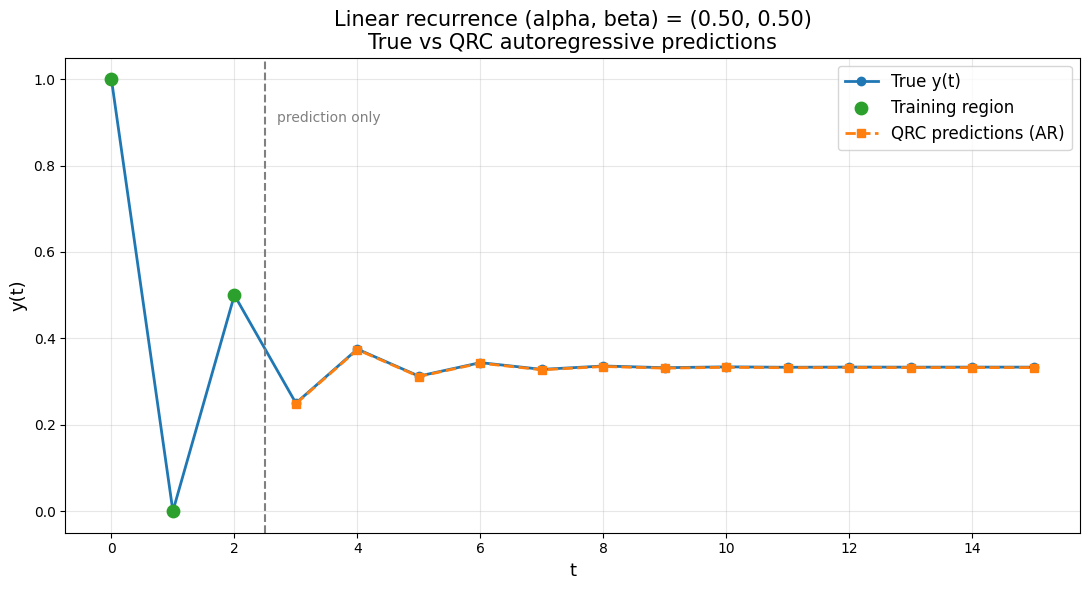

In [ ]:
plot_true_vs_qrc_predictions(
    t_all=t_all,
    y_all=y_all,
    t_start_train=t_start_train,
    t_end_train=t_end_train,
    t_pred=t_pred,
    y_pred_raw=y_pred_raw,
    t_start_pred=t_start_pred,
    alpha=alpha,
    beta=beta,
)
